# DeepHubble

Here, we are exploring the Pro-GAN as describes in [this paper](https://arxiv.org/pdf/1710.10196.pdf)

In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision as torchv
import torchx
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import trange, tqdm
from PIL import Image

## Data

The ground truth data will be sampled from the Hubble eXtreme Deep Field (XDF). As seen below

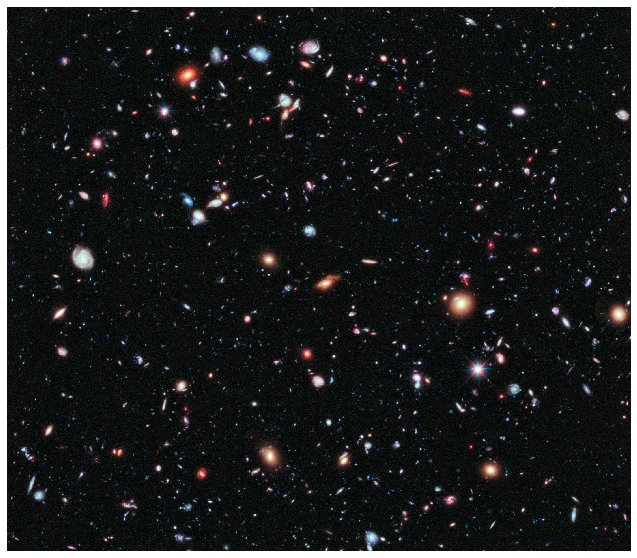

In [2]:
HubbleXDF = Image.open("../data/HubbleXDF_cropped.jpg")

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.imshow(HubbleXDF)
plt.axis('off')
plt.show()

We will be sampling images from the deep field image for our model to learn the distribution for. For the purpose of progressively growing our GAN, we sample $512 \times 512$ images from the XDF and then scale it down to $4\times4$ and then scaling back up as we train. For example:

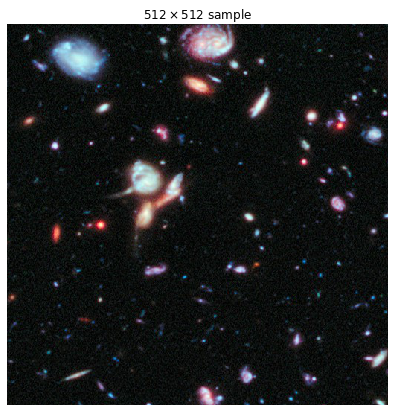

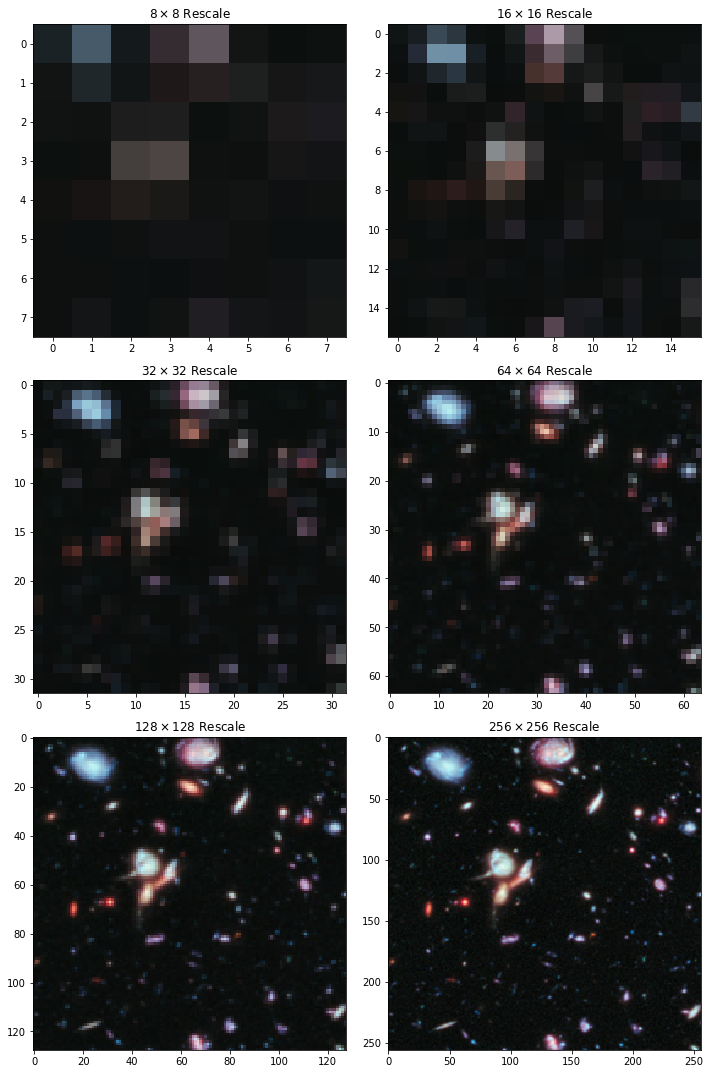

In [3]:
def sample_image(width, height):
    random.seed(20120925)  # Date the XDF was captured: September 25th, 2012
    return torchv.transforms.Compose([
        torchv.transforms.RandomCrop((512, 512)),
        torchv.transforms.Resize((width, height)),
    ])(HubbleXDF)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.imshow(sample_image(512, 512))
plt.axis("off")
plt.title(r"$512 \times 512$ sample")
plt.show()

fig, ax = plt.subplots(3, 2, figsize=(10, 15))
fig.tight_layout()
ax[0][0].imshow(sample_image(8, 8))
ax[0][0].set_title(r"$8 \times 8$ Rescale")
ax[0][1].imshow(sample_image(16, 16))
ax[0][1].set_title(r"$16 \times 16$ Rescale")
ax[1][0].imshow(sample_image(32, 32))
ax[1][0].set_title(r"$32 \times 32$ Rescale")
ax[1][1].imshow(sample_image(64, 64))
ax[1][1].set_title(r"$64 \times 64$ Rescale")
ax[2][0].imshow(sample_image(128, 128))
ax[2][0].set_title(r"$128 \times 128$ Rescale")
ax[2][1].imshow(sample_image(256, 256))
ax[2][1].set_title(r"$256 \times 256$ Rescale")
plt.show()

In [4]:
class Dataset:
    def __init__(self, dim=64, size=96000):
        self.dim = dim
        self.size = size
        
        self.transforms = torchv.transforms.Compose([
            torchv.transforms.RandomCrop((512, 512)),
            torchv.transforms.Resize((self.dim, self.dim)),
            torchv.transforms.ToTensor()
        ])
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, index):
        return self.transforms(HubbleXDF)
    
def FromTensor(tensor):
    return np.moveaxis(fake_output.detach().cpu().numpy(), 1, -1)

## Training

In [5]:
def train(generator, discriminator, dataloader, epochs=10):
    criterion = torch.nn.BCELoss()
    
    generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0005, betas=(0.5, 0.999))
    
    iteration = 0
    
    with SummaryWriter("../data/runs", flush_secs=10) as writer:
        for epoch in trange(epochs):
            with tqdm(total=len(dataloader), leave=False) as progress:
                generator.train()
                discriminator.train()
                progress.set_description(f"epoch {epoch+1}")

                generator_loss = 0
                discriminator_loss = 0

                for i, imgs in enumerate(dataloader):
                    imgs = imgs.cuda()

                    discriminator.zero_grad()

                    real_output = discriminator.forward(imgs)
                    discriminator_err_real = criterion(
                        real_output,                               
                        torch.ones(imgs.shape[0]).cuda()
                    )

                    noise = torch.randn(imgs.shape[0], 100).cuda()
                    fake_output = generator.forward(noise)
                    discriminator_err_fake = criterion(
                        discriminator.forward(fake_output.detach()), 
                        torch.zeros(imgs.shape[0]).cuda()
                    )

                    discriminator_err = discriminator_err_real + discriminator_err_fake
                    discriminator_err.backward()
                    discriminator_optimizer.step()

                    generator.zero_grad()

                    generator_err = criterion(
                        discriminator.forward(fake_output), 
                        torch.ones(imgs.shape[0]).cuda()
                    )
                    generator_err.backward()
                    generator_optimizer.step()

                    progress.set_postfix(dloss="%.6f" % discriminator_err.item(), gloss="%.6f" % generator_err.item())
                    progress.update()

                    generator_loss += generator_err.item()
                    discriminator_loss += discriminator_err.item()
                    if i % 10 == 9:
                        iteration += 1
                        writer.add_scalar("Generator/Loss", generator_loss / 10, iteration)
                        writer.add_scalar("Discriminator/Loss", discriminator_loss / 10, iteration)

                        generator_loss = 0
                        discriminator_loss = 0

                generator.save(f"../data/checkpoints/latest_generator.pt")
                discriminator.save(f"../data/checkpoints/latest_discriminator.pt")

## Model Architectures

The architectures for the generator and discriminator models for the samples are as follows:

In [6]:
dim = 32

In [7]:
class Generator(torchx.nn.Module):
    def __init__(self, input_size=100, output_channels=3):
        super().__init__()
        
        self.input_size = input_size
        self.output_channels = output_channels
        
        self.conv_transpose_8x8 = torch.nn.Sequential(
            torchx.nn.ConvTranspose2dBatch(self.input_size, 64, 4, 1, 0),
            torchx.nn.ConvTranspose2dBatch(64, 256, 4, 2, 1),
        )
        self.conv_transpose_16x16 = torch.nn.Sequential(
            torchx.nn.ConvTranspose2dBatch(256, 256, 4, 2, 1),
            torchx.nn.ConvTranspose2dBatch(256, 256, 3, 1, 1),
        )
        self.conv_transpose_32x32 = torch.nn.Sequential(
            torchx.nn.ConvTranspose2dBatch(256, 256, 4, 2, 1),
            torchx.nn.ConvTranspose2dBatch(256, 256, 3, 1, 1),
        )
#         self.conv_transpose_64x64 = torch.nn.Sequential(
#             torchx.nn.ConvTranspose2dBatch(256, 256, 4, 2, 1),
#             torchx.nn.ConvTranspose2dBatch(256, 256, 3, 1, 1),
#         )
        self.final = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(256, self.output_channels, 3, 1, 1),
            torch.nn.Sigmoid()
        )
        
        self.reset_parameters()
        
    def forward(self, x):
        x = x.view(-1, self.input_size, 1, 1)
        x = self.conv_transpose_8x8(x)
        x = self.conv_transpose_16x16(x)
        x = self.conv_transpose_32x32(x)
#         x = self.conv_transpose_64x64(x)
        return self.final(x)
    

generator = Generator().cuda()
generator.load(f"../data/checkpoints/final_generator_{dim}.pt")

In [8]:
noise = torch.rand([1, 100]).cuda()
assert generator.forward(noise).shape == (1, 3, dim, dim), f"{generator.forward(noise).shape} != {(1, 3, dim, dim)}"

In [9]:
class Discriminator(torchx.nn.Module):
    def __init__(self, input_channels=3):
        super().__init__()
        
        self.input_channels = input_channels

        def Conv2dBatchLeaky(
            in_channels: int,
            out_channels: int,
            kernel_size: int = 3,
            stride: int = 1,
            padding: int = 0,
            bias: bool = False,
            leaky=0.2,
            **kwargs
        ):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.LeakyReLU(leaky, inplace=True),
            )
        
        self.conv_8x8 = torch.nn.Sequential(
            Conv2dBatchLeaky(self.input_channels, 256, 4, 2, 1),
            Conv2dBatchLeaky(256, 256, 3, 1, 1),
        )
        self.conv_16x16 = (
            Conv2dBatchLeaky(256, 256, 4, 2, 1)
        )
        self.conv_32x32 = torch.nn.Sequential(
            Conv2dBatchLeaky(256, 256, 3, 1, 1),
            Conv2dBatchLeaky(256, 256, 4, 2, 1)
        )
#         self.conv_64x64 = (
#             Conv2dBatchLeaky(256, 256, 4, 2, 1)
#         )
        
        self.fc = torch.nn.Sequential(
            torch.nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # FC with Conv.
        )
        
        self.reset_parameters()
        
    def forward(self, x):
        x = self.conv_8x8(x)
        x = self.conv_16x16(x)
        x = self.conv_32x32(x)
#         x = self.conv_64x64(x)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return torch.flatten(x, 0)
    

discriminator = Discriminator().cuda()
discriminator.load(f"../data/checkpoints/final_discriminator_{dim}.pt")

In [10]:
imgs = torch.rand([1, 3, dim, dim]).cuda()
assert discriminator.forward(imgs).shape == (1,)

## Initial Output

As we can see, initially, the generator model outputs random noise

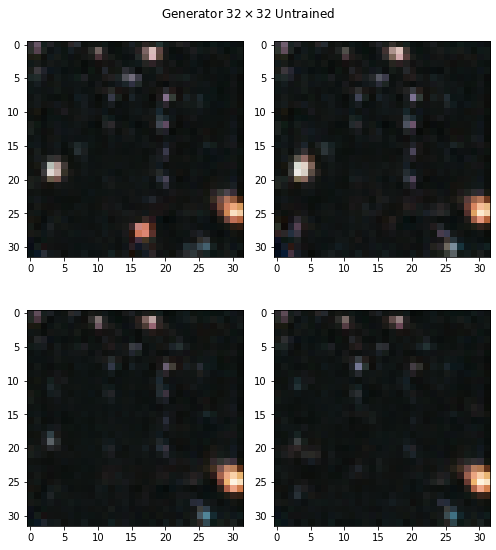

In [11]:
noise = torch.randn(4, 100).cuda()
fake_output = generator.forward(noise)
fake_output = FromTensor(fake_output)

fig, ax = plt.subplots(2, 2, figsize=(7, 8))
fig.tight_layout()
ax[0][0].imshow(fake_output[0])
ax[0][1].imshow(fake_output[1])
ax[1][0].imshow(fake_output[2])
ax[1][1].imshow(fake_output[3])
fig.suptitle(f"Generator ${dim} \\times {dim}$ Untrained")
fig.tight_layout()
plt.savefig(f"../data/images/generator_untrained_{dim}x{dim}.png")
plt.show()

## Generating 16x16 Images

After training, we can use the generator to generate images and see what the generator has learnt

In [12]:
dataloader = torch.utils.data.DataLoader(
    Dataset(dim=dim, size=9600),
    batch_size=64,
    num_workers=8,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

In [13]:
train(generator, discriminator, dataloader, epochs=dim)

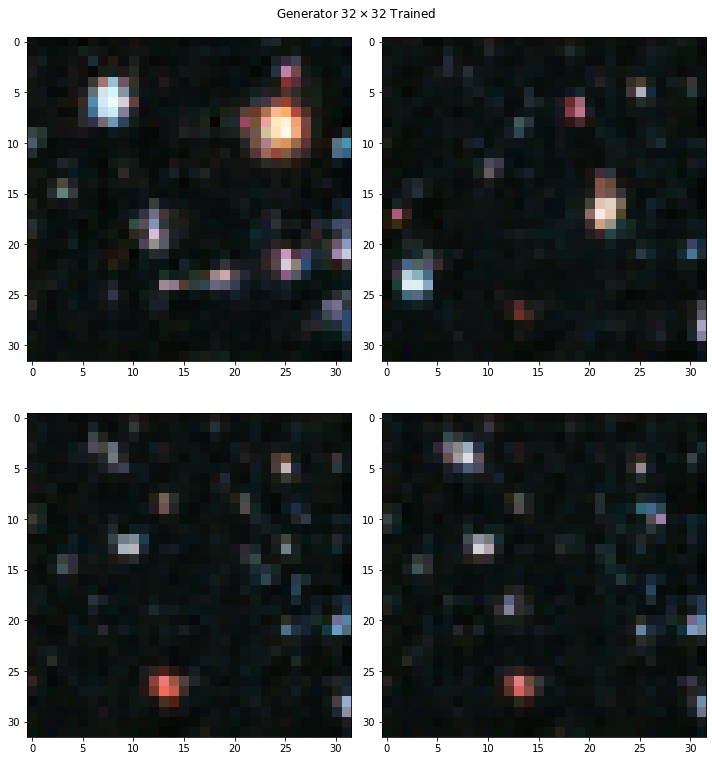

In [21]:
noise = torch.randn(4, 100).cuda()
fake_output = generator.forward(noise)
fake_output = FromTensor(fake_output)

fig, ax = plt.subplots(2, 2, figsize=(10, 11))
fig.tight_layout()
ax[0][0].imshow(fake_output[0])
ax[0][1].imshow(fake_output[1])
ax[1][0].imshow(fake_output[2])
ax[1][1].imshow(fake_output[3])
fig.suptitle(f"Generator ${dim} \\times {dim}$ Trained")
fig.tight_layout()
plt.savefig(f"../data/images/generator_trained_{dim}x{dim}.png")
plt.show()

In [15]:
generator.save(f"../data/checkpoints/final_generator_{dim}.pt")
discriminator.save(f"../data/checkpoints/final_discriminator_{dim}.pt")